In [1]:
from pathlib import Path
from IPython.display import Image

from data_utils import load_import_params, load_results, convert_test_scores_to_sample_scores, get_predictions
from eval import calculate_cf_matrix, plot_cf_matrix, plot_negative_roc
import yaml
import pandas as pd

# Load data

In [2]:
# import parameters
params_path = Path('./params.yml')
import_params = load_import_params(params_path, 'import_params')
export_params = load_import_params(params_path, 'export_params')

# import results.txt file and extract information from file names 
df_results_image_based = load_results(import_params.import_file_path, import_params)
df_results_image_based

,image_name,category,sample,revolution,trigger,truth,good,bad
0,/data/test/bad/BeschStopfen_Stopfen_0025_008_0...,BeschStopfen,25,8,6,bad,0.185450,0.814550
1,/data/test/bad/LyoStopfen_Stopfen_0061_007_01.bmp,LyoStopfen,61,7,1,bad,0.953105,0.046895
2,/data/test/bad/FaserStopfen_Stopfen_0035_006_0...,FaserStopfen,35,6,1,bad,0.873429,0.126571
3,/data/test/bad/MarkStopfen_Stopfen_0057_004_09...,MarkStopfen,57,4,9,bad,0.158839,0.841161
4,/data/test/bad/MarkStopfen_Stopfen_0055_007_06...,MarkStopfen,55,7,6,bad,0.037489,0.962511
...,...,...,...,...,...,...,...,...
12245,/data/test/bad/FaserStopfen_Stopfen_0069_008_1...,FaserStopfen,69,8,10,bad,0.292102,0.707898
12246,/data/test/bad/LyoStopfen_Stopfen_0010_005_07.bmp,LyoStopfen,10,5,7,bad,0.008839,0.991161
12247,/data/test/good/FaserStopfen_Stopfen_0042_001_...,FaserStopfen,42,1,10,good,0.284208,0.715792
12248,/data/test/good/PartikelIglo_Stopfen_0004_004_...,PartikelIglo,4,4,4,good,0.805709,0.194291


# Filter categories and save data frame

In [3]:
# filter relevant categories
include_categories = [
    'Airline',
    'Verformt',
    'BeschStopfen_',
    'MarkStopfen_',
    'PartikelIglo_',
    'FaserStopfen',
    'LyoStopfen',
    'Gut'
]

with open(params_path, 'r') as file:
    params = yaml.safe_load(file)
    export_params = params['export_params']

# df_results_image_based = df_results_image_based[df_results_image_based.category.isin(include_categories)]

# save new data frame to csv file
export_path = Path(export_params['export_path'])
path_image_based_csv = export_path / 'image_based_scores.csv'
df_results_image_based.to_csv(path_image_based_csv)

# Image-based evaluation

Converting scores to indices: {'good': 0, 'bad': 1}


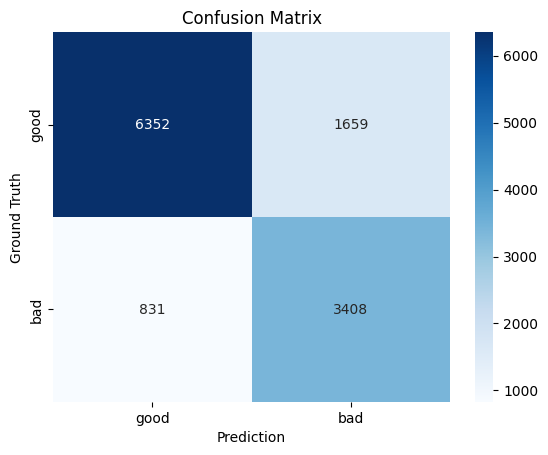

In [4]:
# creating confusion matrix
print(f'Converting scores to indices: {import_params.prediction_categories_to_index}')
y_true = df_results_image_based.truth.apply(lambda x: import_params.prediction_categories_to_index[x])
y_pred = get_predictions (df_results_image_based[import_params.prediction_categories], import_params)
y_pred = y_pred.apply(lambda x: import_params.prediction_categories_to_index[x])
cf_matrix = calculate_cf_matrix(y_true, y_pred, import_params)

# plotting and saving confusion matrix
save_path_cf_matrix = export_path / 'image_based_cf_matrix.png'
plot_cf_matrix(cf_matrix, save_path_cf_matrix, import_params.prediction_categories)

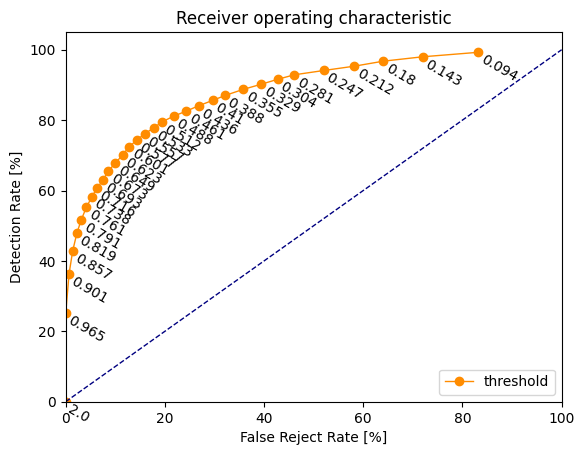

In [5]:
# plotting and saving ROC curve
# y_scores = df_results_image_based.negative_score
y_scores = df_results_image_based[import_params.negative_classes].apply(max, axis = 1)
y_scores.head()
save_path_ROC_curve = export_path / 'image_based_ROC_curve.png'

plot_negative_roc(y_true, y_scores, save_path_ROC_curve, n = 100, negative_label=1)

# Sample-based evaluation

In [6]:
# convert image based results into sample based results
# prediction is calculated by getting the highest negative score and checking if it is higher than import_params.threshold
df_results_sample_based = convert_test_scores_to_sample_scores(df_results_image_based, import_params)
df_results_sample_based

,category,sample,revolution,bad,negative_score,prediction,truth
0,BeschStopfen,1,5,0.229833,0.229833,0,1
1,BeschStopfen,1,6,0.573005,0.573005,1,1
2,BeschStopfen,1,7,0.352661,0.352661,0,1
3,BeschStopfen,1,8,0.729608,0.729608,1,1
4,BeschStopfen,1,9,0.577831,0.577831,1,1
...,...,...,...,...,...,...,...
1640,PartikelIglo,73,6,0.857903,0.857903,1,1
1641,PartikelIglo,73,7,0.739723,0.739723,1,1
1642,PartikelIglo,73,8,0.871865,0.871865,1,1
1643,PartikelIglo,73,9,0.786038,0.786038,1,1


In [7]:
# save sample based data frame to csv file
save_path_sample_based_csv= export_path / 'sample_based_test_scores.csv'
df_results_sample_based.to_csv(save_path_sample_based_csv)

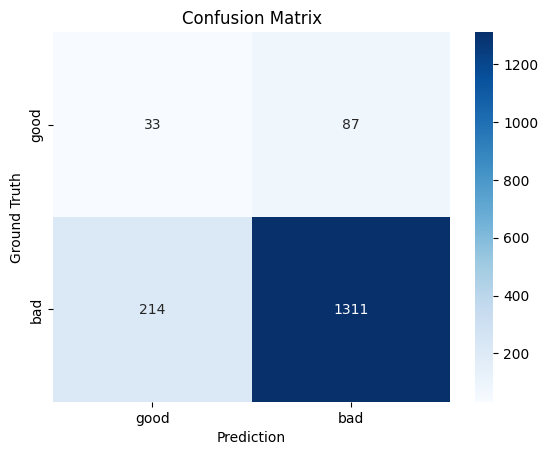

In [8]:
# creating confusion matrix
y_true = df_results_sample_based.truth
y_pred = df_results_sample_based.prediction

cf_matrix = calculate_cf_matrix(y_true, y_pred, import_params)

# plotting and saving confusion matrix
save_path_cf_matrix = export_path / 'sample_based_cf_matrix.png'
plot_cf_matrix(cf_matrix, save_path_cf_matrix, import_params.prediction_categories)

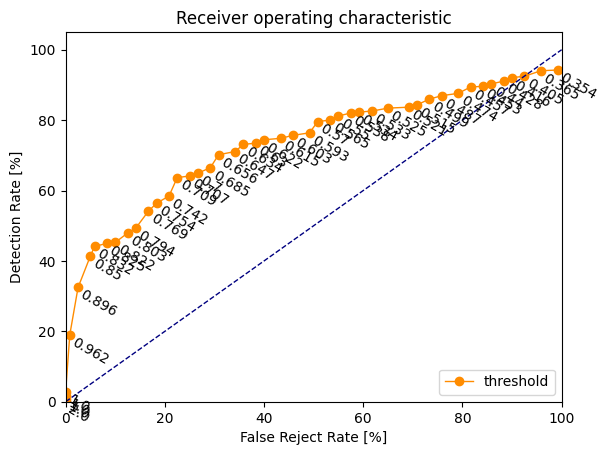

In [9]:
# plotting and saving ROC curve
y_scores = df_results_sample_based.negative_score
save_path_ROC_curve = export_path / 'sample_based_ROC_curve.png'

plot_negative_roc(y_true, y_scores, save_path_ROC_curve, n = 5, negative_label=1)